# Width graphs for 1:8 and 1:6

In [1]:
import numpy as np
import glob
import pickle
from matplotlib import pyplot as plt
from matplotlib import colors
%matplotlib inline

from cube_fil_finder.util import moments
from cube_fil_finder.galfa import galfa_util
from cube_fil_finder.galfa import galfa_v_lookup
from cube_fil_finder.galfa import galfa_const

In [31]:
reload(galfa_const)

<module 'cube_fil_finder.galfa.galfa_const' from '/Users/larryli/Documents/CC/16-17/research/3d_filfind/cube_fil_finder/galfa/galfa_const.py'>

In [3]:
# get trees and widths
pickle_path_all_sky_1_8 = '../pickled_dicts/all_sky_1_8_cut/all_sky_1_8.p'
trees_all_sky_1_8 = pickle.load(open(pickle_path_all_sky_1_8, 'rb'))
pickle_path_all_sky_1_8_width = '../pickled_dicts/all_sky_1_8_cut/fwhm_fits_1_8.p'
widths_all_sky_1_8 = pickle.load(open(pickle_path_all_sky_1_8_width))

In [22]:
galfa_v_lookup_list = galfa_v_lookup.GALFA_V_LOOKUP_W

In [23]:
# filter out none values
bad_keys = []
for k in widths_all_sky_1_8:
    if widths_all_sky_1_8[k] is None:
        bad_keys.append(k)
for k in bad_keys:
    del trees_all_sky_1_8[k]
    del widths_all_sky_1_8[k]
    
print('we are left with {} trees'.format(len(trees_all_sky_1_8)))

we are left with 232 trees


In [24]:
# split into data np arrays
keys_1_8 = trees_all_sky_1_8.keys()
keys_1_8.sort()

# widths
widths_1_8 = np.asarray([widths_all_sky_1_8[k] for k in keys_1_8])

# velocity span
v_lengths_1_8_ind = np.asarray([trees_all_sky_1_8[k].length for k in keys_1_8])
v_lengths = v_lengths_1_8_ind * (np.mean(np.diff(galfa_v_lookup_list)))

# averge velocities
vs_1_8_ind = np.asarray([trees_all_sky_1_8[k].root_v_slice for k in keys_1_8])
vs_1_8_ind = vs_1_8_ind + v_lengths_1_8_ind / 2.
vs_1_8 = np.asarray([galfa_util.galfa_v_lookup_from_index(v_ind) for v_ind in vs_1_8_ind])

# ls & bs
ls_1_8 = []
bs_1_8 = []
for k in keys_1_8:
    this_tree = trees_all_sky_1_8[k]
    # get galfa index of tree centroid
    this_tree_galfa_ind = np.asarray(this_tree.root_node.corner_BL) + moments.get_tree_mask_centroid(this_tree)
    # convert galfa index of tree centroid to l&b
    this_tree_l, this_tree_b = galfa_util.galfa_index_to_lb(*this_tree_galfa_ind)
    ls_1_8.append(this_tree_l)
    bs_1_8.append(this_tree_b)
ls_1_8 = np.asarray(ls_1_8)
bs_1_8 = np.asarray(bs_1_8)

In [49]:
import glob
from astropy.io import fits

masked_area_size_1_8 = []
sum_0th_moment_1_8 = []
#sum_1st_moment_1_8 = []
sum_column_density_1_8 = []
peak_column_density_1_8 = []


DATA_SLICE_BASE_DIR = '/Volumes/LarryExternal1/Research_2017/GALFA_slices_backup/umask_gaussian_30/'

for key in keys_1_8:
    this_node = trees_all_sky_1_8[key]
    slice_files_list = []
    for i in range(this_node.length):
        slice_file_name = glob.glob(DATA_SLICE_BASE_DIR + '*{0}*'.format(str(this_node.root_v_slice + i)))[0]
        slice_files_list.append(slice_file_name)

    this_structure_cube = []
    for f in slice_files_list:
        full_slice, hdr = fits.getdata(f, header=True)
        corners = this_node.root_node.corners
        structure_slice = full_slice[corners[0][1]:corners[1][1], corners[0][0]:corners[1][0]]
        this_structure_cube.append(structure_slice)

    zeroth_moment_map = create_0th_moment_map(this_structure_cube)
    column_density_map = get_column_density(zeroth_moment_map, this_node.root_v_slice, this_node.length)
    
    masked_zeroth_moment_map = mask_map(zeroth_moment_map, this_node.root_node.mask)
    masked_column_density_map = mask_map(column_density_map, this_node.root_node.mask)
    
    masked_area_size_1_8.append(this_node.root_node.masked_area_size)
    sum_0th_moment_1_8.append(np.sum(masked_zeroth_moment_map))
    sum_column_density_1_8.append(np.sum(masked_column_density_map))
    peak_column_density_1_8.append(np.max(masked_column_density_map))

In [50]:
masked_area_size_1_8 = np.asarray(masked_area_size_1_8)
sum_0th_moment_1_8 = np.asarray(sum_0th_moment_1_8)
sum_column_density_1_8 = np.asarray(sum_column_density_1_8)
peak_column_density_1_8 = np.asarray(peak_column_density_1_8)

In [51]:
avg_0th_moment_1_8 = sum_0th_moment_1_8 / masked_area_size_1_8
avg_column_density = sum_column_density_1_8 / masked_area_size_1_8

In [7]:
ex_tree = trees_all_sky_1_8['11482_1030_0']
print(ex_tree.root_node.corners)
print(ex_tree.root_node.corner_BL)
print(ex_tree.root_node.corner_TR)

[[17945, 1276], [18440, 1428]]
[17945, 1276]
[18440, 1428]


In [45]:
peak_column_density_1_8

[5.8484793033377759e+19]

### width vs galactic latitude

/Users/larryli/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


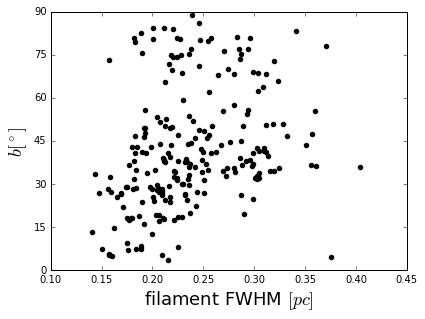

In [8]:
fig1, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4.5))

ax.scatter(widths_1_8, np.abs(bs_1_8), marker='o', color='black')

ax.set_ylabel(r'$b [^\circ]$', fontsize=18)
ax.set_xlabel(r'filament FWHM $[pc]$', fontsize=18)

ax.set_ylim([0, 90])
ax.set_xlim([0.1, 0.45]) # consistent with histograms

ax.set_yticks(np.linspace(0, 90, 7))
ax.set_xticks(np.linspace(0.1, 0.45, 8))

fig1.tight_layout()
fig1.show()

In [9]:
fig1.savefig('../vis/width_distributions/width_vs_abs_b.pdf')

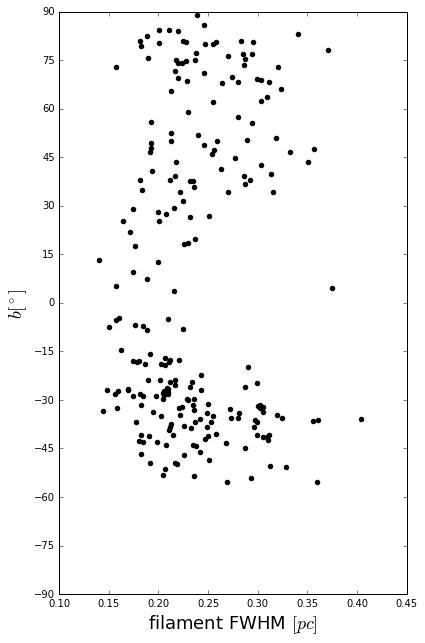

In [10]:
fig12, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,9))

ax.scatter(widths_1_8, bs_1_8, marker='o', color='black')

ax.set_ylabel(r'$b [^\circ]$', fontsize=18)
ax.set_xlabel(r'filament FWHM $[pc]$', fontsize=18)

ax.set_ylim([-90, 90])
ax.set_xlim([0.1, 0.45]) # consistent with histograms

ax.set_yticks(np.linspace(-90,90,13))
ax.set_xticks(np.linspace(0.1, 0.45, 8))

fig12.tight_layout()
fig12.show()

In [11]:
fig12.savefig('../vis/width_distributions/width_vs_b.pdf')

### width vs galactic longitude

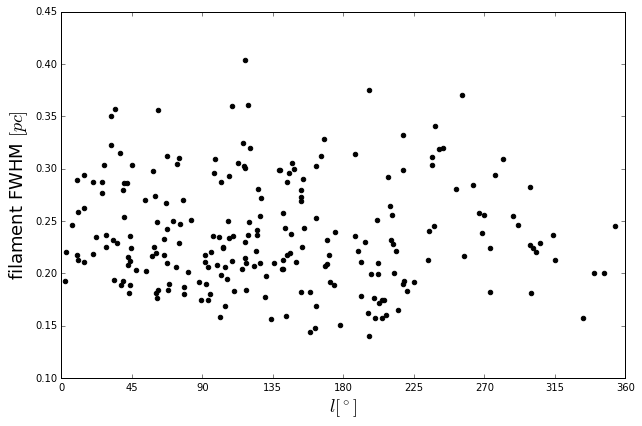

In [12]:
fig2, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,6))

ax.scatter(ls_1_8, widths_1_8, marker='o', color='black')

ax.set_xlabel(r'$l [^\circ]$', fontsize=18)
ax.set_ylabel(r'filament FWHM $[pc]$', fontsize=18)

ax.set_xlim([0, 360])
ax.set_ylim([0.1, 0.45]) # consistent with histograms

ax.set_xticks(np.linspace(0, 360, 9))
ax.set_yticks(np.linspace(0.1, 0.45, 8))

fig2.tight_layout()
fig2.show()

In [13]:
fig2.savefig('../vis/width_distributions/l_vs_width.pdf')

### width vs velocity

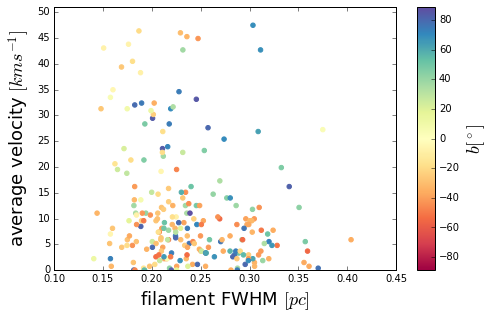

In [104]:
fig3, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,4.5))

max_b = np.max(bs_1_8)
ax.scatter(widths_1_8, abs(vs_1_8), c=bs_1_8,
           norm=plt.Normalize(vmin=-max_b, vmax=max_b), marker='o', cmap='Spectral', edgecolors='face')

sm = plt.cm.ScalarMappable(cmap='Spectral',
                           norm=plt.Normalize(vmin=-max_b, vmax=max_b))
sm._A = []
cbar = fig3.colorbar(sm, ax=ax, aspect=15, shrink=1)
cbar.set_label(r'$b [^\circ]$', fontsize=18)

ax.set_xlabel(r'filament FWHM $[pc]$', fontsize=18)
ax.set_ylabel(r'average velocity $[km s^{-1}]$', fontsize=18)

#ax.set_ylim([-51, 51])
ax.set_ylim([0,51])
ax.set_xlim([0.1, 0.45]) # consistent with histograms

#ax.set_yticks(np.linspace(-50, 50, 11))
ax.set_yticks(np.linspace(0, 50, 11))
ax.set_xticks(np.linspace(.1, .45, 8))

fig3.tight_layout()
fig3.show()

In [15]:
fig3.savefig('../vis/width_distributions/width_vs_avg_v.pdf')

### Peak column density vs with

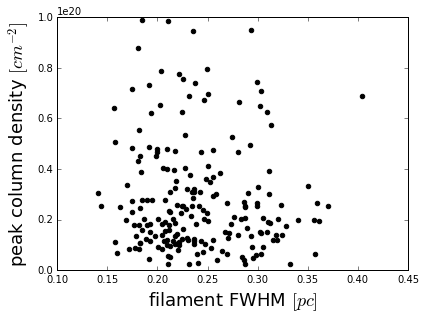

In [89]:
fig4, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4.5))

ax.scatter(widths_1_8, peak_column_density_1_8, marker='o', color='black')

ax.set_ylabel(r'peak column density $[cm^{-2}]$', fontsize=18)
ax.set_xlabel(r'filament FWHM $[pc]$', fontsize=18)

ax.set_ylim([0, 1e20])
ax.set_xlim([0.1, 0.45]) # consistent with histograms

ax.set_xticks(np.linspace(0.1, 0.45, 8))

fig4.tight_layout()
fig4.show()

In [69]:
fig4.savefig('../vis/width_distributions/width_vs_peak_column_density.pdf')

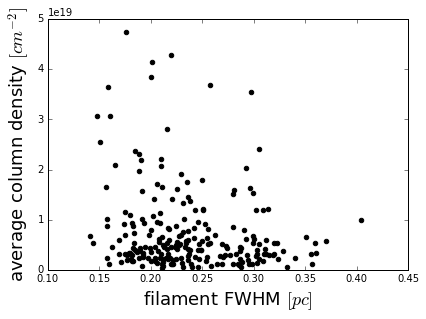

In [94]:
fig41, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4.5))

ax.scatter(widths_1_8, avg_column_density, marker='o', color='black')

ax.set_ylabel(r'average column density $[cm^{-2}]$', fontsize=18)
ax.set_xlabel(r'filament FWHM $[pc]$', fontsize=18)

ax.set_ylim([0, .5e20])
ax.set_xlim([0.1, 0.45]) # consistent with histograms

ax.set_xticks(np.linspace(0.1, 0.45, 8))

fig41.tight_layout()
fig41.show()

In [ ]:
fig41, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4.5))

ax.scatter(widths_1_8, avg_column_density, marker='o', color='black')

ax.set_ylabel(r'average column density $[cm^{-2}]$', fontsize=18)
ax.set_xlabel(r'filament FWHM $[pc]$', fontsize=18)

ax.set_ylim([0, .5e20])
ax.set_xlim([0.1, 0.45]) # consistent with histograms

ax.set_xticks(np.linspace(0.1, 0.45, 8))

fig41.tight_layout()
fig41.show()

### Peak column density vs b

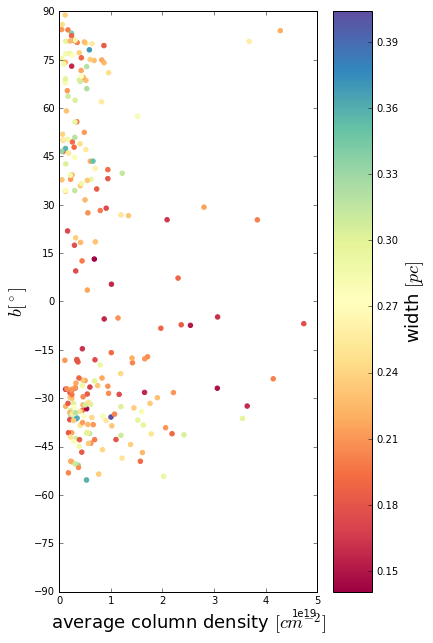

In [103]:
fig5, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,9))

ax.scatter(avg_column_density, bs_1_8, c=widths_1_8, marker='o', cmap='Spectral', edgecolors='face')

sm = plt.cm.ScalarMappable(cmap='Spectral',
                           norm=plt.Normalize(vmin=min(widths_1_8), vmax=max(widths_1_8)))
sm._A = []
cbar = fig3.colorbar(sm, ax=ax, aspect=15, shrink=1)
cbar.set_label(r'width $[pc]$', fontsize=18)

ax.set_ylabel(r'$b [^\circ]$', fontsize=18)
ax.set_xlabel(r'average column density $[cm^{-2}]$', fontsize=18)

ax.set_ylim([-90, 90])
ax.set_xlim([0, .5e20]) # consistent with histograms

ax.set_yticks(np.arange(-90, 90.1, 15))
#ax.set_xticks(np.linspace(0.1, 0.45, 8))

fig5.tight_layout()
fig5.show()

In [70]:
fig5.savefig('../vis/width_distributions/peak_column_density_vs_b.pdf')

### linewidth vs width

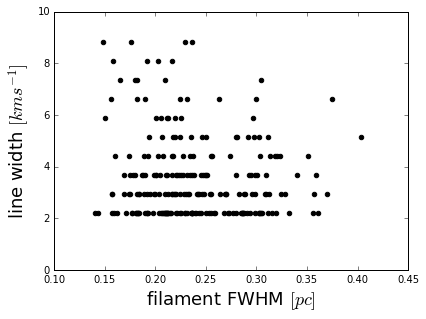

In [83]:
fig5, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4.5))

ax.scatter(widths_1_8, v_lengths, marker='o', color='black')

ax.set_ylabel(r'line width $[kms^{-1}]$', fontsize=18)
ax.set_xlabel(r'filament FWHM $[pc]$', fontsize=18)

ax.set_ylim([0, 10])
ax.set_xlim([0.1, 0.45]) # consistent with histograms

ax.set_xticks(np.linspace(0.1, 0.45, 8))

fig5.tight_layout()
fig5.show()

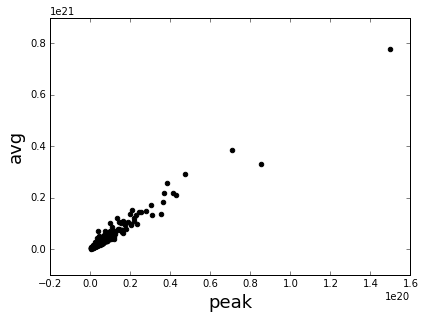

In [105]:
fig5, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4.5))

ax.scatter(avg_column_density, peak_column_density_1_8, marker='o', color='black')

ax.set_ylabel(r'avg', fontsize=18)
ax.set_xlabel(r'peak', fontsize=18)

#ax.set_ylim([0, 10])
#ax.set_xlim([0.1, 0.45]) # consistent with histograms

#ax.set_xticks(np.linspace(0.1, 0.45, 8))

fig5.tight_layout()
fig5.show()

In [ ]:
^ look at some of the big ones

### Saving to table

In [8]:
a = np.asarray([[1, 1, 1],[3, 5, 6],[7, 2, 3]])
b = np.asarray([[1, 1, 1],[3, 77, 6],[7, 2, 3]])
c = np.asarray([[1, 1, 1],[3, 99, 6],[7, 2, 3]])

In [5]:
np.shape(a) == np.shape(a)

True

In [10]:
d = [a,b,c]

In [14]:
e = np.asarray(d)